In [1]:
import jax.numpy as jnp
import jax.scipy.stats as jst
from jax.random import PRNGKey, normal, split
import matplotlib.pyplot as plt
import numpy as np

from kernels import kernel_factory
from utils import *
from integrators import *

root_seed=12387593871
key = PRNGKey(root_seed)


from test_functions import *

2023-03-21 00:30:28.032811: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-21 00:30:28.181243: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-21 00:30:28.182711: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-21 00:30:29.632053: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-21 00:30:29.632101: W external/org

In [2]:
U = neg_log_wave()
prob = wave()

ey, split_key = split(key)
# q_init = normal(split_key, (dim, ))
walkers = 100
q_init = normal(key, (2, ))

In [9]:
num_warmup = 1000
num_samples = 200000
keys = split(key, num=num_samples+num_warmup)
dual_avg_kwargs = None
init_step_size = .1

init_state, mcmc_kernel = kernel_factory("mcmc", q_init, init_step_size, prob, None, gather_stats=True, dual_avg_kwargs=dual_avg_kwargs)

carry, burned_mcmc_states = jax.lax.scan(mcmc_kernel, init_state, keys[:num_warmup,:]) # warm up
carry, mcmc_states = jax.lax.scan(mcmc_kernel, carry, keys[num_warmup:,:])

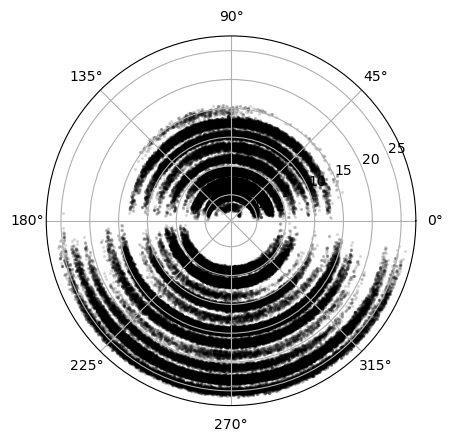

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(*mcmc_states[0].T, s=2, c='k', alpha=0.1)

In [16]:
q, accept_prob, step_size = [np.concatenate((arr, mcmc_states[i])) for i, arr in enumerate(burned_mcmc_states)]
print(f"Final step size: {step_size[-1]}")

running_avg_a_rate,_,_ = compute_stats(np.expand_dims(accept_prob, axis=1))
print(f"Final average acceptance rate: {running_avg_a_rate[-1]}")


fig, axes = plt.subplots(1,2, figsize=(15,5))

x = np.arange(num_warmup)

axes[0].plot(x, running_avg_a_rate[:num_warmup])
axes[0].scatter(x, accept_prob[:num_warmup], s=1, c='grey')
axes[1].plot(x, step_size[:num_warmup])


x = np.arange(num_warmup, num_samples+num_warmup)
axes[0].plot(x, running_avg_a_rate[num_warmup:])
axes[0].scatter(x, accept_prob[num_warmup:], s=1, c='k')
axes[1].plot(x, step_size[num_warmup:])

ValueError: not enough values to unpack (expected 3, got 2)

In [13]:
num_warmup = 1000
num_samples = 200000
keys = split(key, num=num_samples+num_warmup)
dual_avg_kwargs = {"tune_steps":num_warmup, "target_accept":0.65}
init_step_size=.25 # too small and it will be a random walk too

initial_state, hmc_kernel = kernel_factory("hmc", q_init, init_step_size, U, explicit_leapfrog, num_steps=2, gather_stats=True, dual_avg_kwargs=dual_avg_kwargs)

carry, burned_hmc_states = jax.lax.scan(hmc_kernel, initial_state, keys[:num_warmup,:]) # warm up
carry, hmc_states = jax.lax.scan(hmc_kernel, carry, keys[num_warmup:,:])

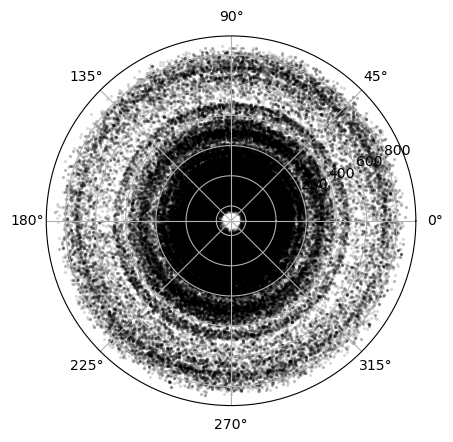

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(*hmc_states[0].T, s=2, c='k', alpha=0.1)

Final step size: 1.1277810335159302
Final average acceptance rate: [0.6289284]


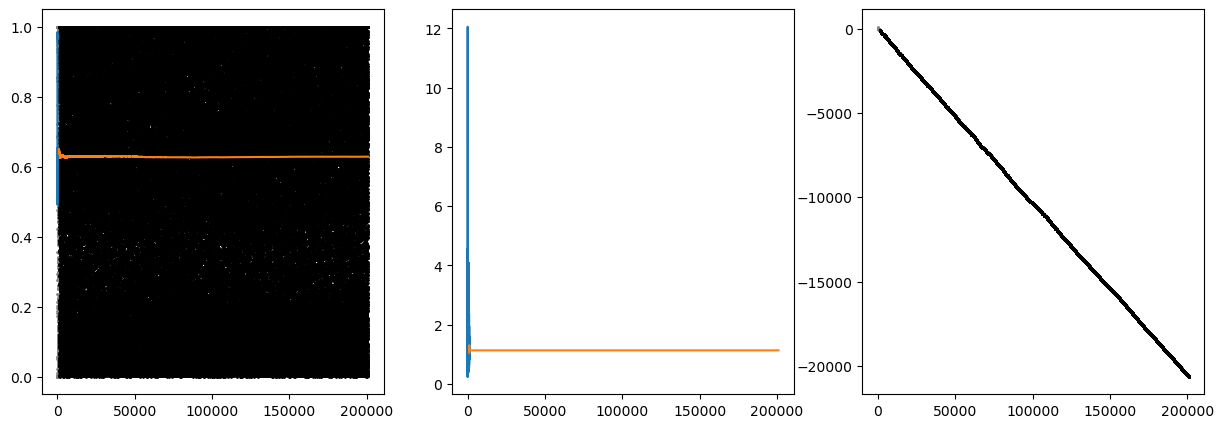

In [18]:
q, accept_prob, E_new, step_size = [np.concatenate((arr, hmc_states[i])) for i, arr in enumerate(burned_hmc_states)]
print(f"Final step size: {step_size[-1]}")

running_avg_a_rate,_,_ = compute_stats(np.expand_dims(accept_prob, axis=1))
print(f"Final average acceptance rate: {running_avg_a_rate[-1]}")


fig, axes = plt.subplots(1,3, figsize=(15,5))

x = np.arange(num_warmup)

axes[0].plot(x, running_avg_a_rate[:num_warmup])
axes[0].scatter(x, accept_prob[:num_warmup], s=1, c='grey')
axes[1].plot(x, step_size[:num_warmup])
axes[2].scatter(x, E_new[:num_warmup], s=1, c='grey')


x = np.arange(num_warmup, num_samples+num_warmup)
axes[0].plot(x, running_avg_a_rate[num_warmup:])
axes[0].scatter(x, accept_prob[num_warmup:], s=1, c='k')
axes[1].plot(x, step_size[num_warmup:])
axes[2].scatter(x, E_new[num_warmup:], s=1, c='k')


### Parallel?

In [ ]:
import blackjax

observed = np.random.normal(10, 20, size=1_000)

# Build the kernel
step_size = 1e-3
inverse_mass_matrix = jnp.array([1., 1.])
hmc = blackjax.hmc(U, step_size, inverse_mass_matrix)

# Initialize the state
initial_position = {"loc": 1., "scale": 2.}
state = hmc.init(initial_position)


def inference_loop_multiple_chains(
    rng_key, kernel, initial_state, num_samples, num_chains
):

    @jax.jit
    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        states, _ = jax.vmap(kernel)(keys, states)
        return states, states

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

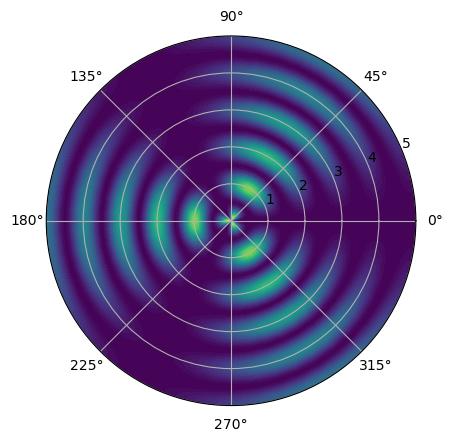

In [69]:
r, theta = np.linspace(0, 5, 50), np.linspace(0, 2*np.pi, 50)
r, theta = np.meshgrid(r, theta)



fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.contourf(theta, r, , 50)

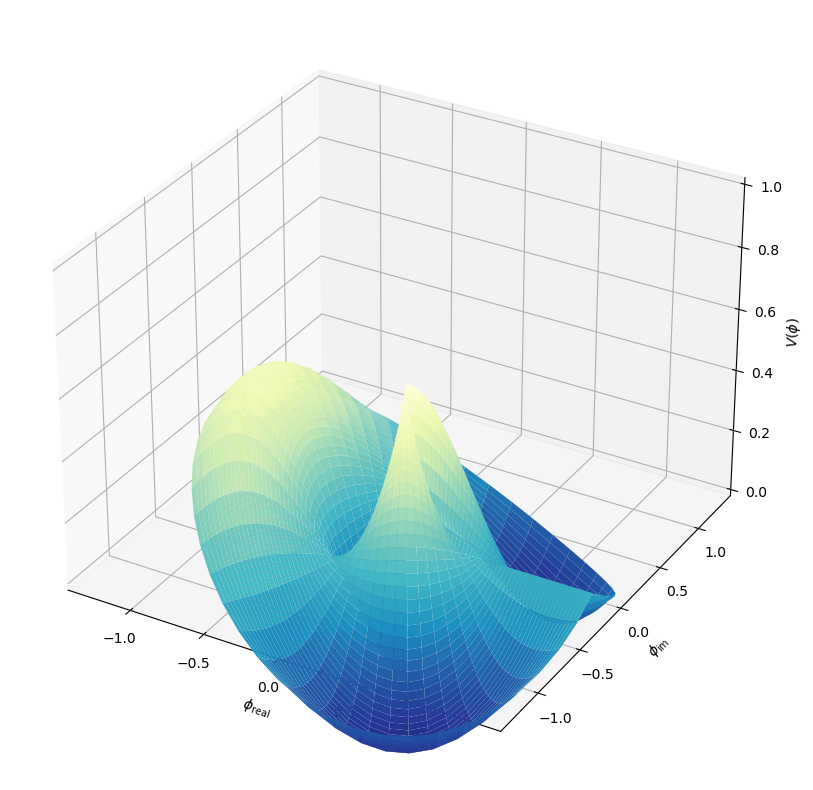

In [77]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

# Create the mesh in polar coordinates and compute corresponding Z.
r = np.linspace(0, 1.25, 50)
theta = np.linspace(0, 2*np.pi, 50)
r, theta = np.meshgrid(r, theta)
z = .5*np.exp(-.2*r)*(np.sin(1.5*theta)*np.cos(np.pi*r))

# Express the mesh in the cartesian system.
x, y = r*np.cos(theta), r*np.sin(theta)

# Plot the surface.
ax.plot_surface(x,y,z, cmap=plt.cm.YlGnBu_r)

# Tweak the limits and add latex math labels.
ax.set_zlim(0, 1)
ax.set_xlabel(r'$\phi_\mathrm{real}$')
ax.set_ylabel(r'$\phi_\mathrm{im}$')
ax.set_zlabel(r'$V(\phi)$')

plt.show()

In [43]:
import mpl_toolkits.mplot3d.axes3d as axes3d
from jax.scipy.special import sph_harm

theta, phi = np.linspace(0, 2 * np.pi, 40), np.linspace(0, np.pi, 40)
theta, phi = np.meshgrid(theta, phi)

x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)


m,l = 2,3

# Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
fcolors = sph_harm(m, l, theta, phi).real
fmax, fmin = fcolors.max(), fcolors.min()
fcolors = (fcolors - fmin)/(fmax - fmin)

# Set the aspect ratio to 1 so our sphere looks spherical
# fig = plt.figure(figsize=plt.figaspect(1.))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.seismic(fcolors))


ValueError: Incompatible shapes for broadcasting: (40, 40) and requested shape (3, 40)

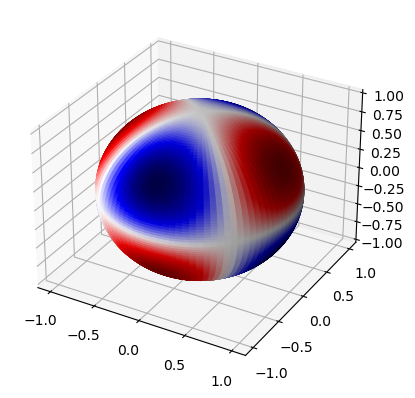

In [40]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.special import sph_harm

phi = np.linspace(0, np.pi, 100)
theta = np.linspace(0, 2*np.pi, 100)
phi, theta = np.meshgrid(phi, theta)

# The Cartesian coordinates of the unit sphere
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

m, l = 2, 3

# Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
fcolors = sph_harm(m, l, theta, phi).real
fmax, fmin = fcolors.max(), fcolors.min()
fcolors = (fcolors - fmin)/(fmax - fmin)

# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.seismic(fcolors))